In [29]:

import pandas as pd
import math
import sklearn.preprocessing
import datetime
from TimeBasedCV import TimeBasedCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import make_scorer, r2_score
import statsmodels.api as sm
import pickle
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.linear_model import HuberRegressor
# pd.set_option('display.max_rows', None)
# more
import matplotlib.pyplot as plt

In [30]:
# df = pd.read_csv('data/factors_1965.csv', parse_dates=['DATE'])

In [31]:
# with open('data/features_1965.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('data/features_1965.pkl', 'rb') as f:
    df = pickle.load(f)
    print(df.head())



   permno       DATE        mvel1      beta    betasq     chmom     dolvol  \
0   10145 1965-02-26   1498872.00  0.983510  0.967291  0.105988  11.546907   
1   10401 1965-02-26  35392058.00  0.780829  0.609694 -0.063768  12.240330   
2   10786 1965-02-26   1695284.75  0.806119  0.649827 -0.130519  12.005040   
3   10989 1965-02-26   1295887.75  1.199748  1.439395  0.073609  11.756961   
4   11260 1965-02-26   2302001.25  1.257269  1.580725 -0.167320  12.240330   

    idiovol    indmom     mom1m  ...  macro_ep  macro_bm  macro_ntis  \
0  0.022307  0.035075  0.104116  ...  2.936836  0.471399    0.014823   
1  0.013395  0.335139 -0.007326  ...  2.936836  0.471399    0.014823   
2  0.024366  0.104106  0.060498  ...  2.936836  0.471399    0.014823   
3  0.022717  0.118513  0.068807  ...  2.936836  0.471399    0.014823   
4  0.035883  0.185424 -0.036885  ...  2.936836  0.471399    0.014823   

   macro_tbl  macro_tms  macro_dfy  macro_svar  macro_mkt-rf  macro_hml  \
0     0.0393    -0.0379

In [32]:
#Sort observations by date and stock id
df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
df = df.sort_values(by = ['DATE', 'permno'], ascending = True)

In [33]:
df['permno2'] = df['permno'].copy()
df['DATE2'] = df['DATE'].copy()
df['mvel12'] = df['mvel1'].copy()
df = df.set_index(['DATE2','permno2'])


In [34]:
p=0.3 
df_top= df.groupby('DATE').apply(lambda x: x.nlargest(int(len(x)*p),'mvel1')).reset_index(drop=True)  
df_bottom = df.groupby('DATE').apply(lambda x: x.nsmallest(int(len(x)*p),'mvel1')).reset_index(drop=True)  

In [35]:

def calculate_r2(y_true, y_pred, in_sample=True, benchmark=None):
    if in_sample:
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - np.mean(y_true)) ** 2))
    else:
        if benchmark is None:
            raise ValueError("Benchmark must be provided for out-of-sample R-squared calculation.")
        return 1 - (np.sum((y_true - y_pred) ** 2) / 
                    np.sum((y_true - benchmark) ** 2))

In [36]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium'])].tolist()
df[features]=df.groupby('DATE')[features].rank(pct=True)

df[features] = 2*df[features] - 1

df_top[features]=df_top.groupby('DATE')[features].rank(pct=True)
df_top[features] = 2*df_top[features] - 1

df_bottom[features]=df_bottom.groupby('DATE')[features].rank(pct=True)
df_bottom[features] = 2*df_bottom[features] - 1

In [45]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()

X = df[features]
y = df[['risk_premium']]

predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):


    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    #OLS regression with huber loss function
    reg_huber = HuberRegressor(max_iter=1000)
    #No hyperparameters in OLS --> use df and validation set for training
    reg_huber.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    #Use test set to generate predictions
    preds = reg_huber.predict(X_test) 
    #Save predictions, dates and the true values of the dependent variable to list  
    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    #Calculate OOS model performance the for current window
    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    #Save OOS model performance and the respective month to dictionary
    dic_r2_all["r2." + str(y_test.index)] = r2
   
    
    
#Concatenate to get results over the whole OOS test period (Jan 2010-Dec 2019)
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

#Calculate OOS model performance over the entire test period in line with Gu et al (2020)
# R2OOS_LR = 1-np.sum(pow(y_test_list_all-predictions_all,2))/np.sum(pow(y_test_list_all,2))
# print("R2OOS Hubber Regression: ", R2OOS_LR)
R2FULL = r2_score(y_test_list_all, predictions_all)
R2FULL

Train period: 1965-01-31 - 1975-01-31 ,val period: 1975-01-31 - 1977-01-31 , Test period 1977-01-31 - 1978-01-31 # train records 13670 ,# val records 3499 , # test records 1941
Train period: 1966-01-31 - 1976-01-31 ,val period: 1976-01-31 - 1978-01-31 , Test period 1978-01-31 - 1979-01-31 # train records 14434 ,# val records 3708 , # test records 2030
Train period: 1967-01-31 - 1977-01-31 ,val period: 1977-01-31 - 1979-01-31 , Test period 1979-01-31 - 1980-01-31 # train records 15118 ,# val records 3971 , # test records 2358
Train period: 1968-01-31 - 1978-01-31 ,val period: 1978-01-31 - 1980-01-31 , Test period 1980-01-31 - 1981-01-31 # train records 15843 ,# val records 4388 , # test records 3334
Train period: 1969-01-31 - 1979-01-31 ,val period: 1979-01-31 - 1981-01-31 , Test period 1981-01-31 - 1982-01-31 # train records 16573 ,# val records 5692 , # test records 3578
Train period: 1970-01-31 - 1980-01-31 ,val period: 1980-01-31 - 1982-01-31 , Test period 1982-01-31 - 1983-01-31 # 

0.017843548796471653

In [44]:

tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12','sic2' , 'DATE2', 'risk_premium'])].tolist()

X = df_top[features]
y = df_top[['risk_premium']]

predictions_top = []
y_test_list_top =[]
dates_top = []
dic_r2_all_top = {}

for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1975,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]

    reg_huber = HuberRegressor(max_iter=1000)
    reg_huber.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))


    preds = reg_huber.predict(X_test)    
    predictions_top.append(preds)
    dates_top.append(y_test.index)
    y_test_list_top.append(y_test)
    
    r2_top = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    dic_r2_all_top["r2." + str(y_test.index)] = r2

predictions_all_top= np.concatenate(predictions_top, axis=0)
y_test_list_all_top= np.concatenate(y_test_list_top, axis=0) 
dates_all_top= np.concatenate(dates_top, axis=0)

R2TOP = r2_score(y_test_list_all_top, predictions_all_top)
R2TOP

Train period: 1965-01-31 - 1975-01-31 ,val period: 1975-01-31 - 1977-01-31 , Test period 1977-01-31 - 1978-01-31 # train records 4042 ,# val records 1040 , # test records 577
Train period: 1966-01-31 - 1976-01-31 ,val period: 1976-01-31 - 1978-01-31 , Test period 1978-01-31 - 1979-01-31 # train records 4271 ,# val records 1103 , # test records 603
Train period: 1967-01-31 - 1977-01-31 ,val period: 1977-01-31 - 1979-01-31 , Test period 1979-01-31 - 1980-01-31 # train records 4478 ,# val records 1180 , # test records 704
Train period: 1968-01-31 - 1978-01-31 ,val period: 1978-01-31 - 1980-01-31 , Test period 1980-01-31 - 1981-01-31 # train records 4696 ,# val records 1307 , # test records 995
Train period: 1969-01-31 - 1979-01-31 ,val period: 1979-01-31 - 1981-01-31 , Test period 1981-01-31 - 1982-01-31 # train records 4915 ,# val records 1699 , # test records 1068
Train period: 1970-01-31 - 1980-01-31 ,val period: 1980-01-31 - 1982-01-31 , Test period 1982-01-31 - 1983-01-31 # train rec

0.02852792295233364

In [11]:
tscv = TimeBasedCV(train_period=120,
                   val_period=24,
                   test_period=12,
                   freq='months')


features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12','sic2' , 'DATE2', 'risk_premium'])].tolist()
X = df_bottom[features]
y = df_bottom[['risk_premium']]

#Empty containers to save results from each window

predictions_bottom = []
y_test_list_bottom =[]
dates_bottom = []
dic_r2_all_bottom = {}

for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1975,1,31), second_split_date= datetime.date(1985,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]

    reg_huber = HuberRegressor(max_iter=1000)
    reg_huber.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))


    preds = reg_huber.predict(X_test)    
    predictions_bottom.append(preds)
    dates_bottom.append(y_test.index)
    y_test_list_bottom.append(y_test)
    
    r2_bottom = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    dic_r2_all_bottom["r2." + str(y_test.index)] = r2

predictions_all_bottom= np.concatenate(predictions_bottom, axis=0)
y_test_list_all_bottom= np.concatenate(y_test_list_bottom, axis=0) 
dates_all_bottom= np.concatenate(dates_bottom, axis=0)

R2BOTTOM = r2_score(y_test_list_all_bottom, predictions_all_bottom)
R2BOTTOM

Train period: 1965-01-31 - 1975-01-31 ,val period: 1975-01-31 - 1977-01-31 , Test period 1977-01-31 - 1978-01-31 # train records 4042 ,# val records 1040 , # test records 577
Train period: 1966-01-31 - 1976-01-31 ,val period: 1976-01-31 - 1978-01-31 , Test period 1978-01-31 - 1979-01-31 # train records 4271 ,# val records 1103 , # test records 603
Train period: 1967-01-31 - 1977-01-31 ,val period: 1977-01-31 - 1979-01-31 , Test period 1979-01-31 - 1980-01-31 # train records 4478 ,# val records 1180 , # test records 704
Train period: 1968-01-31 - 1978-01-31 ,val period: 1978-01-31 - 1980-01-31 , Test period 1980-01-31 - 1981-01-31 # train records 4696 ,# val records 1307 , # test records 995
Train period: 1969-01-31 - 1979-01-31 ,val period: 1979-01-31 - 1981-01-31 , Test period 1981-01-31 - 1982-01-31 # train records 4915 ,# val records 1699 , # test records 1068
Train period: 1970-01-31 - 1980-01-31 ,val period: 1980-01-31 - 1982-01-31 , Test period 1982-01-31 - 1983-01-31 # train rec

0.01122193460790355

In [12]:
chart = np.array([[R2FULL],
                  [R2TOP],
                  [R2BOTTOM]])

huber = pd.DataFrame(chart, columns=['Huber Regression'],
                     index=['Full Sample', 'Large Firms', 'Small Firms'])

huber

,Huber Regression
Full Sample,0.017844
Large Firms,0.028528
Small Firms,0.011222


In [13]:
huber.to_csv(r'huber_model.csv', index=False)

In [18]:
#Sort observations by date and stock id
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium', 'year'])].tolist()
df['year'] = df['DATE'].dt.year

X_train = df[features].loc[(df["year"]>=2013) & (df["year"]<=2018)]
y_train = df["risk_premium"].loc[(df["year"]>=2013) & (df["year"]<=2018)]

X_val = df[features].loc[(df["year"]>=2018) & (df["year"]<=2020)]
y_val = df["risk_premium"].loc[(df["year"]>=2018) & (df["year"]<=2020)]


huber = HuberRegressor(max_iter=1000)
huber.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
preds = huber.predict(np.concatenate((X_train, X_val))) 

R2OOS_all = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
print(R2OOS_all)

0.03982784639194126


In [19]:
for j in features:
    globals()['df_' + str(j)] =  df.copy()
    globals()['df_' + str(j)][str(j)] = 0

In [20]:
dic = {}
    
for j in features:
    print(j)
    df_var = globals()['df_' + str(j)]
    
    X_train = df_var[features].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]
    y_train = df_var["risk_premium"].loc[(df_var["year"]>=2013) & (df_var["year"]<=2018)]

    X_val = df_var[features].loc[(df_var["year"]>=2018) & (df_var["year"]<=2020)]
    y_val = df_var["risk_premium"].loc[(df["year"]>=2018) & (df_var["year"]<=2020)]
    
    lm_model = HuberRegressor(max_iter=1000)
    lm_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = lm_model.predict(np.concatenate((X_train, X_val))) 

    R2OOS_var = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
    dic['R2OOS_' + str(j)] = R2OOS_var

mvel1
beta
betasq
chmom
dolvol
idiovol
indmom
mom1m
mom6m
mom12m
mom36m
pricedelay
turn
absacc
acc
age
agr
bm
bm_ia
cashdebt
cashpr
cfp
cfp_ia
chatoia
chcsho
chempia
chinv
chpmia
convind
currat
depr
divi
divo
dy
egr
ep
gma
grcapx
grltnoa
herf
hire
invest
lev
lgr
mve_ia
operprof
orgcap
pchcapx_ia
pchcurrat
pchdepr
pchgm_pchsale
pchquick
pchsale_pchinvt
pchsale_pchrect
pchsale_pchxsga
pchsaleinv
pctacc
ps
quick
rd
roic
salecash
saleinv
salerec
securedind
sgr
sin
sp
tang
tb
baspread
ill
maxret
retvol
std_dolvol
std_turn
zerotrade
macro_dp
macro_ep
macro_bm
macro_ntis
macro_tbl
macro_tms
macro_dfy
macro_svar
macro_mkt-rf
macro_hml
macro_smb
mvel12


In [21]:
pd.DataFrame(dic.items())
imp=pd.DataFrame(dic.items(), columns=['Feature', 'R2OOS'])
# Feature: name of the variable whose values are set to zero
imp["Feature"] = imp["Feature"].str[6:]

# Calculate reduction in predictive R2OOS 
imp["red_R2OOS"] = R2OOS_all -imp["R2OOS"]
imp["var_imp"] = imp["red_R2OOS"]/sum(imp["red_R2OOS"])
imp=imp.sort_values(by = ['var_imp'], ascending = False)
imp.head()

,Feature,R2OOS,red_R2OOS,var_imp
54,pchsale_pchxsga,-0.062317,0.102145,0.144685
69,tb,-0.012279,0.052107,0.073808
7,mom1m,0.005438,0.034390,0.048712
63,salerec,0.005443,0.034385,0.048705
14,acc,0.005549,0.034279,0.048555


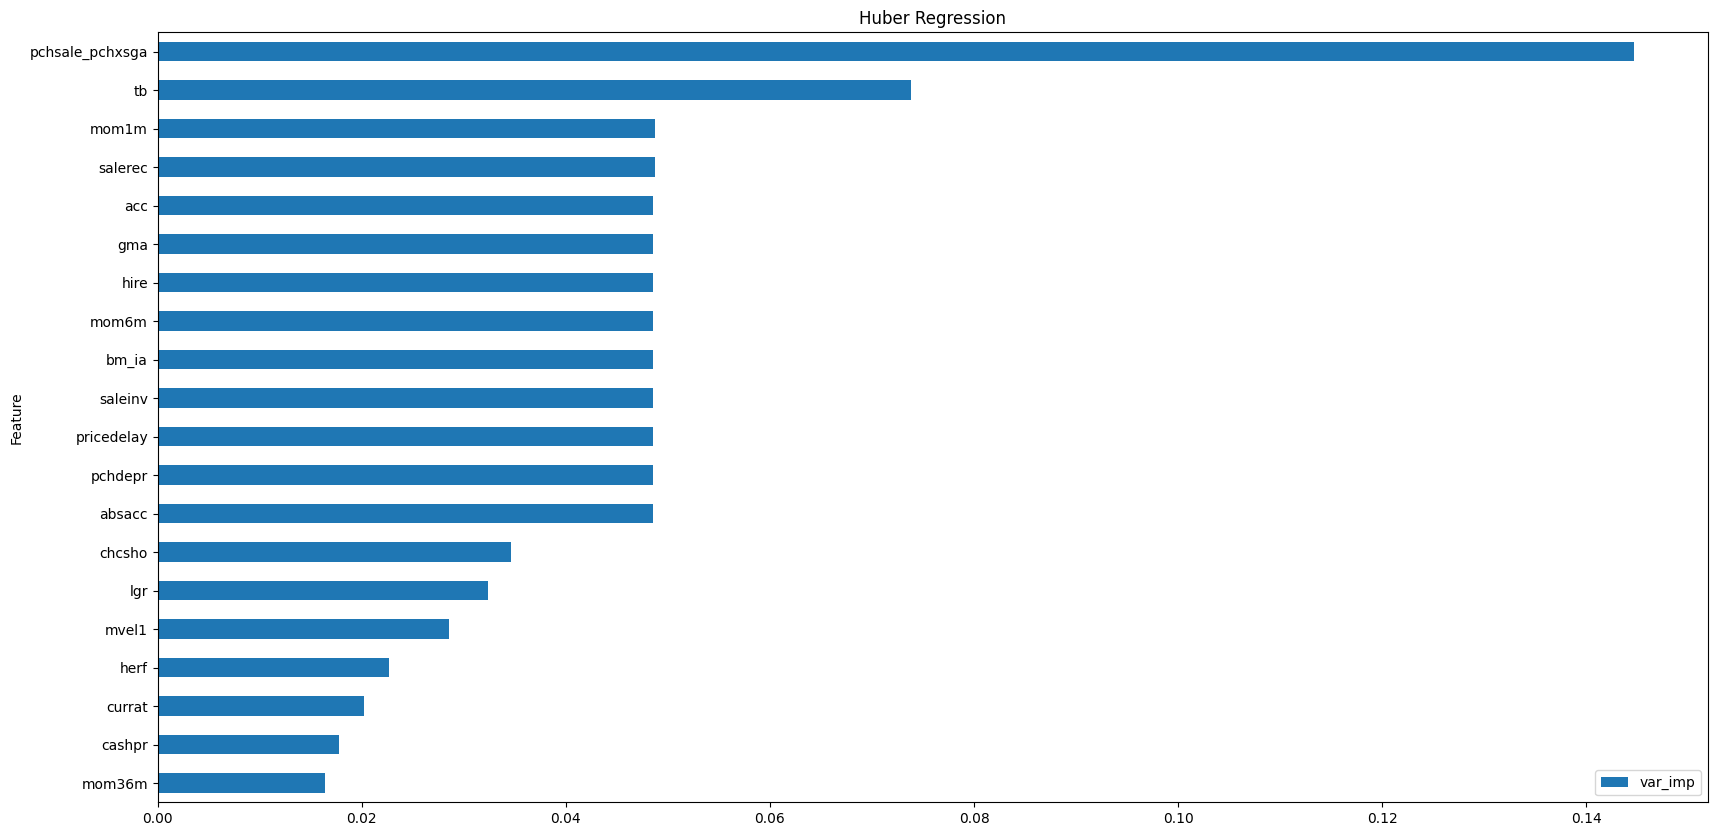

In [23]:
fea_imp_graph = imp.sort_values(['var_imp', 'Feature'], ascending=[True, False]).iloc[-20:]
_ = fea_imp_graph.plot(kind='barh', x='Feature', y='var_imp', figsize=(20, 10))
plt.title('Huber Regression')
plt.show()

In [24]:
var_imp_lm=imp[["Feature", "var_imp"]]
var_imp_lm.to_csv(r'var_imp_huber.csv', index = False)

In [38]:
yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[35:40]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results.head()


# results['yhat'] = results['yhat'].apply(lambda x: x[0])
results['y_true'] = results['y_true'].apply(lambda x: x[0])


data = df[['mvel12', 'macro_tbl', 'macro_svar']].copy()
data.reset_index(inplace=True)
data['permno2'] = data['permno2'].astype('str')
data['MonthYear'] = data['DATE2'].dt.to_period('M')
data.drop('DATE2', axis=1, inplace=True)
data.rename(columns={'permno2': 'id'}, inplace=True)
data.rename(columns={'mvel12': 'market_cap'}, inplace=True)
data.rename(columns={'macro_tbl': 'risk_free_rate'}, inplace=True)
data = data.set_index(['MonthYear','id'])

bigdata = pd.merge(results, data,left_index=True, right_index=True)
bigdata.reset_index(inplace=True)
bigdata
bigdata['returns'] = bigdata['y_true'] + bigdata['risk_free_rate']

In [23]:
bigdata.to_csv('predictions/ols_full.csv', index=False)

In [39]:

bigdata['MonthYear1'] = bigdata['MonthYear'].copy()
bigdata['MonthYear'] = bigdata['MonthYear'].astype('int64')
bigdata['NumMonth'] = bigdata['MonthYear'] - 83
bigdata['NumMonth'].unique()

array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
       229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 25

In [40]:

for i in bigdata['NumMonth'].unique():
    globals()['df_' + str(i)] = bigdata[bigdata['NumMonth'] == i]

for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)]["rank"]= globals()['df_' + str(i)]['yhat'].rank(method='first')
    
for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)]["DecileRank"]=pd.qcut(globals()['df_' + str(i)]['rank'].values, 10, labels = False)

#Drop normal rank, retain only decile ranks 
for i in bigdata["NumMonth"].unique():
     globals()['df_' + str(i)].drop('rank', axis=1, inplace=True)


for i in bigdata["NumMonth"].unique():
    for j,g in globals()['df_' + str(i)].groupby('DecileRank'):
        globals()['df_' + str(i)+ "_" + str(j)] =  g

for j in np.arange(0,10,1):
    globals()['rank_' + str(j)] = pd.concat([globals()['df_1_'+ str(j)], globals()['df_2_'+ str(j)]], axis=0)
    
# Generate 10 Dataframes for the 10 Decile portfolios 0-9: rank_9: top portfolio, rank_0: bottom portfolio
for i in np.arange(2,457,1):
    for j in np.arange(0,10,1):
        globals()['rank_' + str(j)] = pd.concat([globals()['rank_' + str(j)], globals()['df_' + str(i+1)+ "_" + str(j)]], axis = 0)

In [41]:

for j in np.arange(0, 10, 1):
    globals()['rank_' + str(j)] = globals()['rank_' + str(j)].sort_values(['NumMonth', 'yhat'], 
                                    ascending=[True, True]).groupby(['MonthYear'], 
                                                                    as_index=False, sort=False).tail(100)

In [42]:

for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]["eq_weights"] = 1/globals()['rank_' + str(j)].groupby('MonthYear')["id"].transform('size')
    globals()['rank_' + str(j)]['excess_return_stock_ew'] = globals()['rank_' + str(j)]["y_true"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['return_stock_ew'] = globals()['rank_' + str(j)]["returns"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['excess_return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["excess_return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['pred_excess_return_stock_ew'] = globals()['rank_' + str(j)]["yhat"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['pred_excess_return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["pred_excess_return_stock_ew"].transform('sum')

    globals()['monthly_rank_' + str(j)] = globals()['rank_' + str(j)][["MonthYear1", "DecileRank",
                                                                      "excess_return_portfolio_ew",
                                                                      "pred_excess_return_portfolio_ew",
                                                                      "return_portfolio_ew"]]

    globals()['monthly_rank_' + str(j)]=globals()['monthly_rank_' + str(j)].drop_duplicates()

    globals()["ew_mean_return_rank_" +  str(j)]= globals()['monthly_rank_' + str(j)]["excess_return_portfolio_ew"].mean()
    #Time-series average of predicted excess returns
    globals()["ew_mean_pred_return_rank_" +  str(j)]= globals()['monthly_rank_' + str(j)]["pred_excess_return_portfolio_ew"].mean()
    #Standard deviation of realized excess returns
    globals()["std_ew_rank_" +  str(j)]= globals()['monthly_rank_' + str(j)]["excess_return_portfolio_ew"].std()
    #Annualized sharpe ratio of realized excess returns
    globals()["sharpe_ew_rank_" +  str(j)]= (globals()['monthly_rank_' + str(j)]["excess_return_portfolio_ew"].mean()/globals()['monthly_rank_' + str(j)]["return_portfolio_ew"].std())* np.sqrt(12)

In [43]:

chart_np = np.array([[ew_mean_pred_return_rank_0, ew_mean_return_rank_0, std_ew_rank_0, sharpe_ew_rank_0],
                     [ew_mean_pred_return_rank_1, ew_mean_return_rank_1, std_ew_rank_1, sharpe_ew_rank_1],
                     [ew_mean_pred_return_rank_2, ew_mean_return_rank_2, std_ew_rank_2, sharpe_ew_rank_2],
                     [ew_mean_pred_return_rank_3, ew_mean_return_rank_3, std_ew_rank_3, sharpe_ew_rank_3],
                     [ew_mean_pred_return_rank_4, ew_mean_return_rank_4, std_ew_rank_4, sharpe_ew_rank_4],
                     [ew_mean_pred_return_rank_5, ew_mean_return_rank_5, std_ew_rank_5, sharpe_ew_rank_5],
                     [ew_mean_pred_return_rank_6, ew_mean_return_rank_6, std_ew_rank_6, sharpe_ew_rank_6],
                     [ew_mean_pred_return_rank_7, ew_mean_return_rank_7, std_ew_rank_7, sharpe_ew_rank_7],
                     [ew_mean_pred_return_rank_8, ew_mean_return_rank_8, std_ew_rank_8, sharpe_ew_rank_8],
                     [ew_mean_pred_return_rank_9, ew_mean_return_rank_9, std_ew_rank_9, sharpe_ew_rank_9]])

ew_df = pd.DataFrame(chart_np, columns=['Pred', 'Real', 'Std', 'Sharpe'],
                              index=['Low (L)', '2', '3', '4', '5','6','7','8',"9",'High (H)'])
ew_df['Pred'] = pd.Series(["{0:.2f}%".format(val) for val in ew_df['Pred']], index = ew_df.index)
ew_df['Real'] = pd.Series(["{0:.2f}%".format(val) for val in ew_df['Real']], index = ew_df.index)
ew_df['Std'] = pd.Series(["{0:.2f}%".format(val) for val in ew_df['Std']], index = ew_df.index)
ew_df['Sharpe'] = pd.Series([("%.2f" % round(val, 2)) for val in ew_df['Sharpe']], index = ew_df.index)
ew_df

,Pred,Real,Std,Sharpe
Low (L),-6.60%,-4.45%,6.66%,-2.31
2,-6.09%,-4.29%,6.22%,-2.39
3,-5.82%,-4.24%,5.92%,-2.48
4,-5.61%,-4.15%,5.75%,-2.50
5,-5.42%,-4.02%,5.86%,-2.38
6,-5.24%,-4.00%,5.79%,-2.40
7,-5.05%,-3.96%,5.66%,-2.42
8,-4.84%,-3.98%,5.85%,-2.36
9,-4.56%,-3.98%,6.08%,-2.27
High (H),-3.90%,-3.80%,6.57%,-2.01
